In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from datamodules import data_processors
import sys
sys.path.append("..")
print(sys.version)
from rusmodules.inverse import get_constants
from rusmodules.eigenvals import get_eigenvalues

3.13.3 (main, Apr 22 2025, 00:00:00) [GCC 14.2.1 20250110 (Red Hat 14.2.1-7)]


In [2]:
def C_error(C_pred, C_original):
    errors = dict()
    for key in C_pred.keys():
        errors[key + "_error"] = 100*(C_pred[key] - C_original[key])/C_original[key]
    #fin for 
    return errors
#fin función

def organize_matrix(dic_C):
    C = np.zeros((6,6))
    C_prim = np.array(tuple(map(lambda i: tuple(map(lambda j: 1 if i == j and i<3 else 0, range(6))), range(6)))) #Valores de C00, C11, C22
    C_sec = np.array(tuple(map(lambda i: tuple(map(lambda j: 1 if i == j and i >= 3 else 0, range(6))), range(6)))) #Valores de C33, C44, C55
    C_shear_prim = np.array(tuple(map(lambda i: tuple(map(lambda j: 1 if i != j and i<3 and j<3 else 0, range(6))), range(6)))) #Valores de C01, C02, C12
    C_prim = C_prim * dic_C["C00"]
    C_sec = C_sec * dic_C["C33"]
    C_shear_prim = C_shear_prim * dic_C["C01"]
    C = C_prim + C_sec + C_shear_prim
    return C
#fin funcion

def verify_Cs(C_ori, eta, beta, model_data, N_eig = 20, include_x0 = True):
    C = organize_matrix(C_ori)
    eigs = get_eigenvalues(8, C, eta, beta, "Parallelepiped")["eig"][:N_eig]
    C_predicted = get_constants(eigs, eta, beta, model_data, include_x0)
    C_errors = C_error(C_predicted, C_ori)
    return {**C_predicted, **C_errors}
#fin función

<p><b> Let's start testing with the ratio 3:4:5 as reported by Fukuda. That implies: </b></p>

*   $\eta = 2\arctan{\left(\frac{(3^2 + 4^2)^{1/2}}{5} \right)} = \frac{\pi}{2}$

*   $\beta = 4\arctan{\left(\frac{3}{4} \right)} = 0.82\pi$

Also, we need to update the data reported by Fukuda (as a pd.DataFrame called "rp_data"), excecute a forward problem for each row and finally execute the inverse problem importing the model to compare with the predicted values of Fukuda

In [3]:
eta = np.pi/2
beta = 4*np.arctan(3/4)
rp_data = pd.read_csv("../reference_data/Datos_Fukuda.csv")

In [4]:
rp_data

,Unnamed: 0,Ag,AgAl(98.4-1.6),AgAu(96-4),AgBr,AgCd(98.08-1.92),AgCl,AgIn(91.64-8.36),AgMg(96.93-3.07),AgSn(96.83-3.17),...,Th,ThO2,TlCl,UC,UO2,V,ZnS,ZnSe,ZnTe,ZrCo2
0,C11_Predicted(Gpa),114.00,129.90,127.60,47.3,123.1,50.00,107.3,115.3,124.6,...,73.4,350.5,47.7,324.6,371.8,235.20,101.50,75.50,76.60,223.50
1,C12_Predicted(Gpa),87.20,105.50,96.60,21.4,98.4,37.10,78.6,90.6,97.7,...,45.6,80.2,22.6,66.3,86.8,141.40,59.50,45.50,46.90,94.10
2,C44_Predicted(Gpa),46.20,48.40,46.20,6.9,49.6,14.50,40.8,46.9,49.1,...,44.2,63.4,7.5,58.6,64.2,47.20,42.90,44.90,30.40,79.10
3,E1_Predicted(Gpa),38.50,35.30,44.30,33.9,35.7,18.30,40.8,35.6,38.8,...,38.4,320.6,33.2,302.1,339.0,129.00,57.50,41.20,41.00,167.80
4,C11_Reported(Gpa),123.99,128.07,124.27,56.3,121.6,60.10,116.6,119.8,121.0,...,75.3,367.0,40.1,320.0,396.0,227.95,104.62,80.96,71.34,233.11
5,C12_Reported(Gpa),93.67,98.30,92.66,32.8,91.3,36.20,89.0,89.8,92.2,...,48.9,106.0,15.3,85.0,121.0,118.70,65.34,48.81,40.78,112.71
6,C44_Reported(Gpa),46.12,46.43,47.28,7.2,45.9,6.25,45.0,46.0,45.8,...,47.8,79.7,7.6,64.7,64.1,42.55,46.13,44.05,31.15,83.66
7,E1_Reported(Gpa),43.40,42.70,45.10,32.2,43.3,32.90,39.5,42.9,41.3,...,36.8,319.5,31.6,284.3,339.4,146.70,54.40,44.20,41.70,159.60
8,C11_Error(%),-8.10,1.50,2.70,-16.0,1.3,-16.80,-8.0,-3.7,3.0,...,-2.5,-4.5,19.0,1.4,-6.1,3.20,-3.00,-6.80,7.40,-4.10
9,C12_Error(%),-7.00,7.40,4.30,-34.7,7.8,2.50,-11.6,0.9,6.0,...,-6.7,-24.3,47.5,-22.0,-28.3,19.20,-8.90,-6.80,14.90,-16.50


In [5]:
exp_data = rp_data.iloc[4:7]
path_modelo = "models/cubico_L5.keras"
modelo = keras.models.load_model(path_modelo)

In [6]:
stats_modelo = pd.read_csv(path_modelo[:-6]+"_stats.csv")
stats_modelo = stats_modelo.set_index("Unnamed: 0")
dic_stats = dict(map(lambda x: (x, dict(map(lambda y: (y, stats_modelo[y][x]),stats_modelo.keys()))), ["mean", "std"]))
modelo_datos = {"model": modelo, **dic_stats}
modelo_datos

{'model': <Sequential name=sequential, built=True>,
 'mean': {'eta': np.float64(1.187934996930155),
  'beta': np.float64(1.572075872083642),
  'x_0': np.float64(0.0449397804912682),
  'x_1': np.float64(0.0371626191387257),
  'x_2': np.float64(0.0341346071081977),
  'x_3': np.float64(0.0399838025654078),
  'x_4': np.float64(0.0306011682853091),
  'x_5': np.float64(0.0373219248329651),
  'x_6': np.float64(0.0396109670366023),
  'x_7': np.float64(0.0512118236387662),
  'x_8': np.float64(0.0454474276169149),
  'x_9': np.float64(0.041698427434308),
  'x_10': np.float64(0.049895585129733),
  'x_11': np.float64(0.0551466784351865),
  'x_12': np.float64(0.0520978002749908),
  'x_13': np.float64(0.0565800203586329),
  'x_14': np.float64(0.0585140527675135),
  'x_15': np.float64(0.0557604695177499),
  'x_16': np.float64(0.0607498130140616),
  'x_17': np.float64(0.0634658214048105),
  'x_18': np.float64(0.0725910131702187),
  'x_19': np.float64(0.0730861977786367)},
 'std': {'eta': np.float64(0.4

In [7]:
exp_data
exp_data = exp_data.set_index("Unnamed: 0")
rp_data = rp_data.set_index("Unnamed: 0")

In [8]:
key_remap = {"C00": "C11_Pred(Me)", "C01": "C12_Pred(Me)", "C33": "C44_Pred(Me)",
    "C00_error": "C11_Error_Me", "C01_error": "C12_Error_Me", "C33_error": "C44_Error_Me"}
keys_Cs = ["C00", "C01", "C33"]
dic_resultados = dict()
for key in exp_data.keys():
    z_new_sp = np.random.uniform(np.cos(0.61*np.pi), 0.9)
    beta_var = np.random.uniform(0, np.pi)
    eta_var = np.arccos(z_new_sp)
    C_reported = dict(map(lambda i: (keys_Cs[i], exp_data[key][exp_data.index[i]]), range(len(exp_data[key]))))
    calc_pred = verify_Cs(C_reported, eta_var, beta_var, modelo_datos)
    dic_resultados[key] = dict(map(lambda k: (key_remap[k], calc_pred[k]), calc_pred.keys()))
#fin for
df_resultados = pd.DataFrame(dic_resultados)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


/home/cubos/.local/lib/python3.13/site-packages/keras/src/backend/torch/numpy.py:114: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:328.)
  return cast(torch.matmul(x1, x2), result_dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

In [9]:
df_resultados

,Ag,AgAl(98.4-1.6),AgAu(96-4),AgBr,AgCd(98.08-1.92),AgCl,AgIn(91.64-8.36),AgMg(96.93-3.07),AgSn(96.83-3.17),AgZn(97.6-2.4),...,Th,ThO2,TlCl,UC,UO2,V,ZnS,ZnSe,ZnTe,ZrCo2
C11_Pred(Me),122.533073,133.526210,98.233330,56.288961,68.913299,46.826925,113.238124,119.339034,93.422760,117.083612,...,66.415618,293.466253,30.055902,308.832568,277.243599,215.323967,104.071433,77.872344,72.802522,230.252037
C12_Pred(Me),92.868925,107.622507,71.508287,33.682745,41.963018,25.367180,87.264125,94.558725,65.607870,91.213856,...,40.567551,71.936641,9.092095,80.615028,88.247465,109.302368,66.117464,46.234277,42.950030,111.039529
C44_Pred(Me),47.266046,41.194104,43.498663,7.036482,36.971100,5.503310,44.866925,43.888948,45.010544,39.759369,...,41.750969,65.583696,5.797190,62.706856,48.128967,41.630255,45.073950,44.146434,31.172665,83.214565
C11_Error_Me,-1.175036,4.260334,-20.951694,-0.019607,-43.327879,-22.084984,-2.883256,-0.384780,-22.791107,-3.156648,...,-11.798649,-20.036443,-25.047626,-3.489823,-29.988990,-5.538949,-0.524342,-3.813804,2.050073,-1.226015
C12_Error_Me,-0.855210,9.483730,-22.827232,2.691297,-54.038315,-29.924917,-1.950421,5.299248,-28.841790,-0.421555,...,-17.039773,-32.135244,-40.574543,-5.158791,-27.068211,-7.917129,1.189874,-5.277040,5.321308,-1.482096
C44_Error_Me,2.484923,-11.276967,-7.997751,-2.271089,-19.452942,-11.947038,-0.295721,-4.589244,-1.723702,-13.189151,...,-12.654877,-17.711800,-23.721183,-3.080594,-24.915809,-2.161564,-2.289291,0.218921,0.072760,-0.532434


In [10]:
df_reporte = pd.concat((rp_data, df_resultados), axis = 0)

In [11]:
df_reporte.T

,C11_Predicted(Gpa),C12_Predicted(Gpa),C44_Predicted(Gpa),E1_Predicted(Gpa),C11_Reported(Gpa),C12_Reported(Gpa),C44_Reported(Gpa),E1_Reported(Gpa),C11_Error(%),C12_Error(%),C44_Error(%),E1_Error(%),C11_Pred(Me),C12_Pred(Me),C44_Pred(Me),C11_Error_Me,C12_Error_Me,C44_Error_Me
Ag,114.0,87.2,46.2,38.5,123.99,93.67,46.12,43.4,-8.1,-7.0,0.3,-11.3,122.533073,92.868925,47.266046,-1.175036,-0.855210,2.484923
AgAl(98.4-1.6),129.9,105.5,48.4,35.3,128.07,98.30,46.43,42.7,1.5,7.4,4.2,-17.3,133.526210,107.622507,41.194104,4.260334,9.483730,-11.276967
AgAu(96-4),127.6,96.6,46.2,44.3,124.27,92.66,47.28,45.1,2.7,4.3,-2.2,-1.8,98.233330,71.508287,43.498663,-20.951694,-22.827232,-7.997751
AgBr,47.3,21.4,6.9,33.9,56.30,32.80,7.20,32.2,-16.0,-34.7,-4.0,5.5,56.288961,33.682745,7.036482,-0.019607,2.691297,-2.271089
AgCd(98.08-1.92),123.1,98.4,49.6,35.7,121.60,91.30,45.90,43.3,1.3,7.8,8.0,-17.4,68.913299,41.963018,36.971100,-43.327879,-54.038315,-19.452942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,235.2,141.4,47.2,129.0,227.95,118.70,42.55,146.7,3.2,19.2,10.9,-12.1,215.323967,109.302368,41.630255,-5.538949,-7.917129,-2.161564
ZnS,101.5,59.5,42.9,57.5,104.62,65.34,46.13,54.4,-3.0,-8.9,-7.1,5.7,104.071433,66.117464,45.073950,-0.524342,1.189874,-2.289291
ZnSe,75.5,45.5,44.9,41.2,80.96,48.81,44.05,44.2,-6.8,-6.8,1.9,-6.8,77.872344,46.234277,44.146434,-3.813804,-5.277040,0.218921
ZnTe,76.6,46.9,30.4,41.0,71.34,40.78,31.15,41.7,7.4,14.9,-2.4,-1.5,72.802522,42.950030,31.172665,2.050073,5.321308,0.072760


In [12]:
exportar_reporte = True
if exportar_reporte:
    df_reporte.T.to_csv(path_modelo[7:-6] + ".csv")

In [13]:
chambonadas = False
if chambonadas:
    func = lambda x: x
else:
    func = np.abs
#fin if
estadisticas_reporte = {"C00_error": {"Me_abs": np.average(func(df_reporte.T["C11_Error_Me"])), "Fukuda_abs": np.average(func(df_reporte.T["C11_Error(%)"])), 
                                        "Me": np.average(df_reporte.T["C11_Error_Me"]), "Fukuda": np.average(df_reporte.T["C11_Error(%)"])},
                        "C01_error": {"Me_abs": np.average(func(df_reporte.T["C12_Error_Me"])), "Fukuda_abs": np.average(func(df_reporte.T["C12_Error(%)"])),
                                        "Me": np.average(df_reporte.T["C12_Error_Me"]), "Fukuda": np.average(df_reporte.T["C12_Error(%)"])},
                        "C33_error": {"Me_abs": np.average(func(df_reporte.T["C44_Error_Me"])), "Fukuda_abs": np.average(func(df_reporte.T["C44_Error(%)"])),
                                        "Me": np.average(df_reporte.T["C44_Error_Me"]), "Fukuda": np.average(df_reporte.T["C44_Error(%)"])}}
estadisticas_reporte = pd.DataFrame(estadisticas_reporte)

In [14]:
estadisticas_reporte

,C00_error,C01_error,C33_error
Me_abs,9.259630,14.129135,6.842637
Fukuda_abs,5.159459,10.898198,7.785586
Me,-7.875235,-10.211535,-6.382449
Fukuda,1.128829,2.310811,-0.706306


In [15]:
desv_reporte = {"C00_e_std": {"Me_abs": np.std(func(df_reporte.T["C11_Error_Me"])), "Fukuda_abs": np.std(func(df_reporte.T["C11_Error(%)"])), 
                                        "Me": np.std(df_reporte.T["C11_Error_Me"]), "Fukuda": np.std(df_reporte.T["C11_Error(%)"])},
                        "C01_e_std": {"Me_abs": np.std(func(df_reporte.T["C12_Error_Me"])), "Fukuda_abs": np.std(func(df_reporte.T["C12_Error(%)"])),
                                        "Me": np.std(df_reporte.T["C12_Error_Me"]), "Fukuda": np.std(df_reporte.T["C12_Error(%)"])},
                        "C33_e_std": {"Me_abs": np.std(func(df_reporte.T["C44_Error_Me"])), "Fukuda_abs": np.std(func(df_reporte.T["C44_Error(%)"])),
                                        "Me": np.std(df_reporte.T["C44_Error_Me"]), "Fukuda": np.std(df_reporte.T["C44_Error(%)"])}}
desv_reporte = pd.DataFrame(desv_reporte)
estadisticas_reporte = pd.concat((estadisticas_reporte, desv_reporte), axis = 1)

In [16]:
estadisticas_reporte

,C00_error,C01_error,C33_error,C00_e_std,C01_e_std,C33_e_std
Me_abs,9.259630,14.129135,6.842637,10.758645,18.540422,7.262996
Fukuda_abs,5.159459,10.898198,7.785586,5.367996,11.942724,12.922680
Me,-7.875235,-10.211535,-6.382449,11.809737,20.954814,7.670538
Fukuda,1.128829,2.310811,-0.706306,7.359426,16.001860,15.070240


/tmp/ipykernel_58108/2942681792.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(keys_boxplot, rotation=45, ha="right")


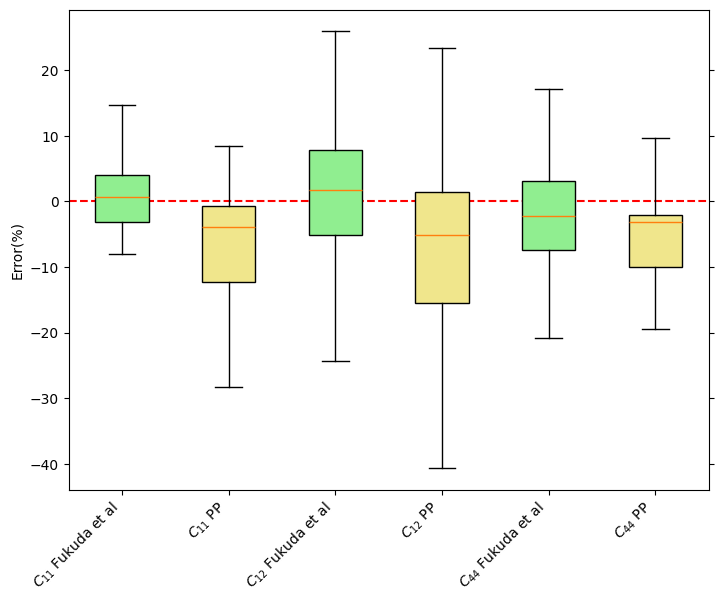

In [17]:
fig_box = plt.figure()
keys_reporte = ("C11_Error(%)", "C11_Error_Me", "C12_Error(%)", "C12_Error_Me", "C44_Error(%)", "C44_Error_Me")
keys_boxplot = (r"$C_{11}$ Fukuda et al", r"$C_{11}$ PP", r"$C_{12}$ Fukuda et al", r"$C_{12}$ PP", r"$C_{44}$ Fukuda et al", r"$C_{44}$ PP")
ax1 = fig_box.add_axes([0, 0, 1, 1])
data = [df_reporte.T[key] for key in keys_reporte]
ax1.set_xticklabels(keys_boxplot, rotation=45, ha="right") 
ax1.yaxis.set_ticks_position('both') 
ax1.set_ylabel("Error(%)")
ax1.axhline(0, color='red', linestyle='--', linewidth=1.5)
colors = ['lightgreen', 'khaki'] * 3

bp1 = ax1.boxplot(data, showfliers=False, patch_artist=True)
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)

/tmp/ipykernel_58108/3081755109.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(keys_boxplot, rotation=45, ha="right")


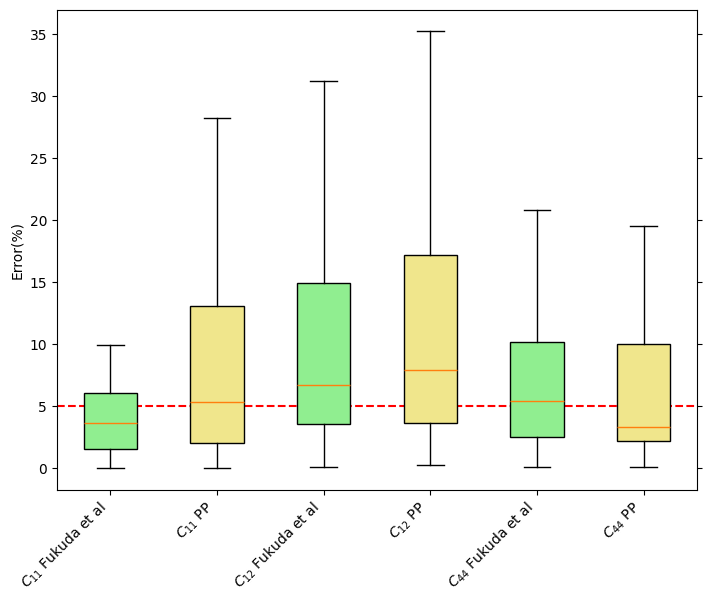

In [18]:
fig_box2 = plt.figure()
keys_reporte = ("C11_Error(%)", "C11_Error_Me", "C12_Error(%)", "C12_Error_Me", "C44_Error(%)", "C44_Error_Me")
keys_boxplot = (r"$C_{11}$ Fukuda et al", r"$C_{11}$ PP", r"$C_{12}$ Fukuda et al", r"$C_{12}$ PP", r"$C_{44}$ Fukuda et al", r"$C_{44}$ PP")
ax2 = fig_box2.add_axes([0, 0, 1, 1])
data2 = [np.abs(df_reporte.T[key]) for key in keys_reporte]
ax2.set_xticklabels(keys_boxplot, rotation=45, ha="right") 
ax2.set_ylabel("Error(%)")
ax2.yaxis.set_ticks_position('both') 
medians = [np.median(d) for d in data2]
ax2.axhline(5, color='red', linestyle='--', linewidth=1.5)
bp2 = ax2.boxplot(data2, showfliers=False, patch_artist=True)
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)

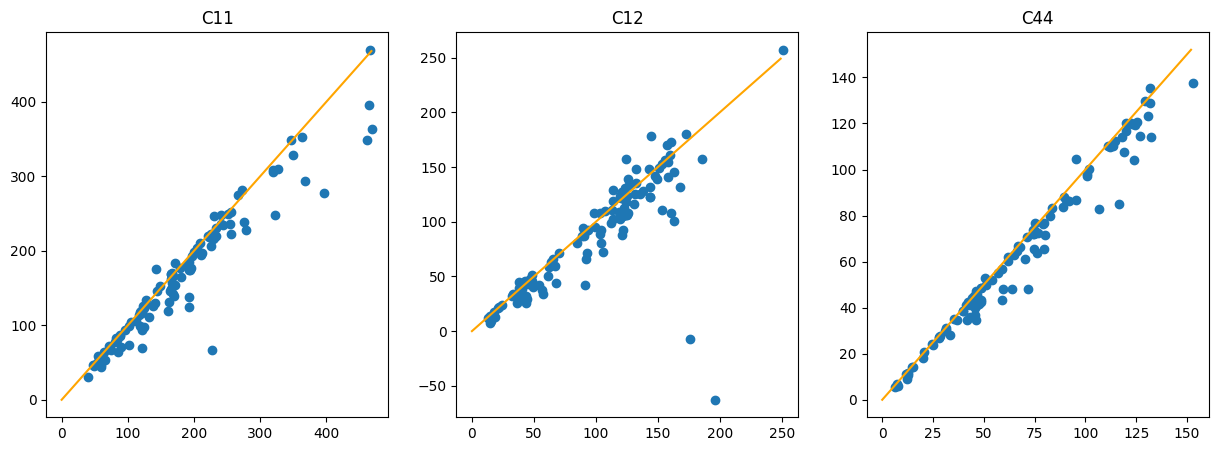

In [19]:
fig_sc1 = plt.figure(figsize = (15,5))
ax1 =fig_sc1.add_subplot(131)
ref1 = range(int(max(df_reporte.T["C11_Reported(Gpa)"])))
ax1.scatter(df_reporte.T["C11_Reported(Gpa)"], df_reporte.T["C11_Pred(Me)"])
ax1.plot(list(ref1), list(ref1), color = "orange")
ax1.set_title("C11")
ax2 =fig_sc1.add_subplot(132)
ref2 = range(int(max(df_reporte.T["C12_Reported(Gpa)"])))
ax2.scatter(df_reporte.T["C12_Reported(Gpa)"], df_reporte.T["C12_Pred(Me)"])
ax2.set_title("C12")
ax2.plot(list(ref2), list(ref2), color = "orange")
ax3 =fig_sc1.add_subplot(133)
ref3 = range(int(max(df_reporte.T["C44_Reported(Gpa)"])))
ax3.scatter(df_reporte.T["C44_Reported(Gpa)"], df_reporte.T["C44_Pred(Me)"])
ax3.set_title("C44")
ax3.plot(list(ref3), list(ref3), color = "orange")

Text(0, 0.5, '$C_{11}$ predicted (GPa)')

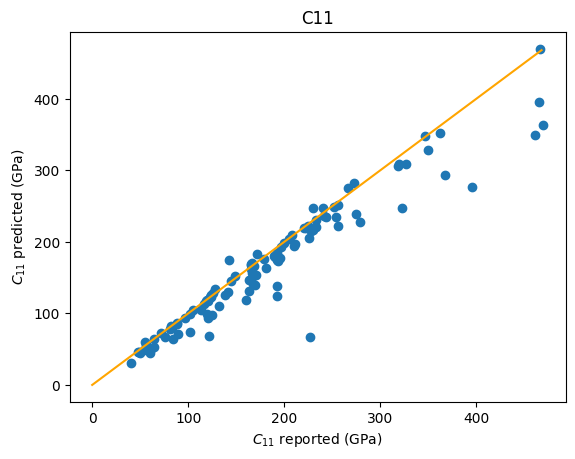

In [20]:
fig_scx = plt.figure()
ax1 =fig_scx.add_subplot(111)
ref1 = range(int(max(df_reporte.T["C11_Reported(Gpa)"])))
ax1.scatter(df_reporte.T["C11_Reported(Gpa)"], df_reporte.T["C11_Pred(Me)"])
ax1.plot(list(ref1), list(ref1), color = "orange")
ax1.set_title("C11")
ax1.set_xlabel(r"$C_{11}$ reported (GPa)")
ax1.set_ylabel(r"$C_{11}$ predicted (GPa)")

Text(0, 0.5, '$C_{12}$ predicted (GPa)')

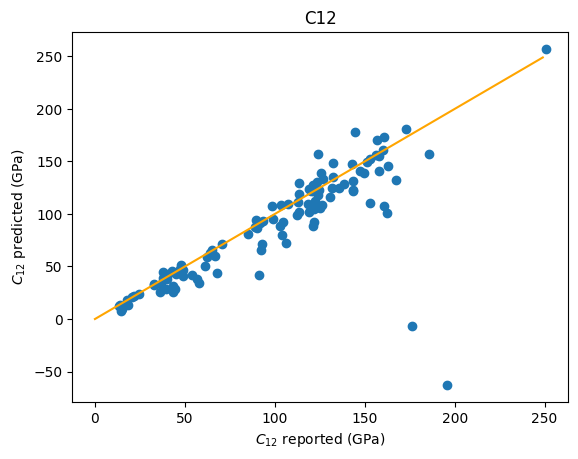

In [21]:
fig_scy = plt.figure()
ax2 =fig_scy.add_subplot(111)
ref2 = range(int(max(df_reporte.T["C12_Reported(Gpa)"])))
ax2.scatter(df_reporte.T["C12_Reported(Gpa)"], df_reporte.T["C12_Pred(Me)"])
ax2.set_title("C12")
ax2.plot(list(ref2), list(ref2), color = "orange")
ax2.set_xlabel(r"$C_{12}$ reported (GPa)")
ax2.set_ylabel(r"$C_{12}$ predicted (GPa)")

Text(0, 0.5, '$C_{44}$ predicted (GPa)')

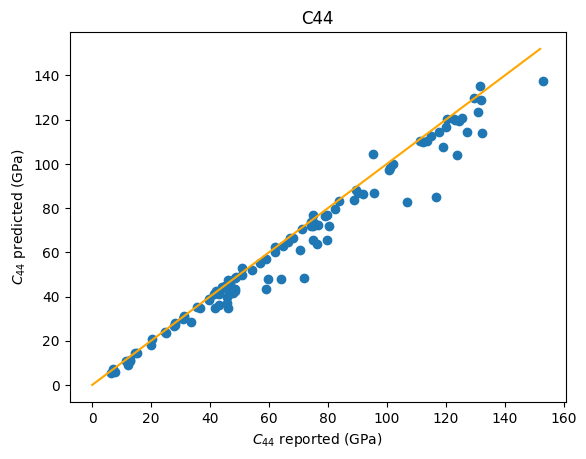

In [22]:
fig_scz = plt.figure()
ax3 =fig_scz.add_subplot(111)
ref3 = range(int(max(df_reporte.T["C44_Reported(Gpa)"])))
ax3.scatter(df_reporte.T["C44_Reported(Gpa)"], df_reporte.T["C44_Pred(Me)"])
ax3.set_title("C44")
ax3.plot(list(ref3), list(ref3), color = "orange")
ax3.set_xlabel(r"$C_{44}$ reported (GPa)")
ax3.set_ylabel(r"$C_{44}$ predicted (GPa)")